In [199]:
import pandas as pd
import yfinance as yf
import numpy as np
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [200]:
# Define the ticker symbol
tickerSymbol = '^GSPC'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2023-11-04')
tickerDf['Date'] = tickerDf.index.date

# See your data
print(tickerDf)

                                  Open         High          Low        Close  \
Date                                                                            
2010-01-04 00:00:00-05:00  1116.560059  1133.869995  1116.560059  1132.989990   
2010-01-05 00:00:00-05:00  1132.660034  1136.630005  1129.660034  1136.520020   
2010-01-06 00:00:00-05:00  1135.709961  1139.189941  1133.949951  1137.140015   
2010-01-07 00:00:00-05:00  1136.270020  1142.459961  1131.319946  1141.689941   
2010-01-08 00:00:00-05:00  1140.520020  1145.390015  1136.219971  1144.979980   
...                                ...          ...          ...          ...   
2023-10-30 00:00:00-04:00  4139.390137  4177.470215  4132.939941  4166.819824   
2023-10-31 00:00:00-04:00  4171.330078  4195.549805  4153.120117  4193.799805   
2023-11-01 00:00:00-04:00  4201.270020  4245.640137  4197.740234  4237.859863   
2023-11-02 00:00:00-04:00  4268.259766  4319.720215  4268.259766  4317.779785   
2023-11-03 00:00:00-04:00  4

In [201]:
## transformation
tickerDf = tickerDf.drop(columns=['Dividends', 'Stock Splits', 'Open'])
tickerDf['Date'] = tickerDf.index.date



In [202]:
tickerDf['Date'] = tickerDf.index.date

# Reset the index to get a default integer index
tickerDf.reset_index(drop=True, inplace=True)

tickerDf = tickerDf[['Date', 'Close', 'Volume']]

tickerDf

,Date,Close,Volume
0,2010-01-04,1132.989990,3991400000
1,2010-01-05,1136.520020,2491020000
2,2010-01-06,1137.140015,4972660000
3,2010-01-07,1141.689941,5270680000
4,2010-01-08,1144.979980,4389590000
...,...,...,...
3479,2023-10-30,4166.819824,3911140000
3480,2023-10-31,4193.799805,4249470000
3481,2023-11-01,4237.859863,4224900000
3482,2023-11-02,4317.779785,4669780000


Calculate daily return

In [203]:
tickerDf['daily_return'] = tickerDf['Close'].pct_change()
tickerDf['state'] = np.where(tickerDf['daily_return'] >= 0, 'up', 'down')

In [204]:
tickerDf

,Date,Close,Volume,daily_return,state
0,2010-01-04,1132.989990,3991400000,NaN,down
1,2010-01-05,1136.520020,2491020000,0.003116,up
2,2010-01-06,1137.140015,4972660000,0.000546,up
3,2010-01-07,1141.689941,5270680000,0.004001,up
4,2010-01-08,1144.979980,4389590000,0.002882,up
...,...,...,...,...,...
3479,2023-10-30,4166.819824,3911140000,0.012010,up
3480,2023-10-31,4193.799805,4249470000,0.006475,up
3481,2023-11-01,4237.859863,4224900000,0.010506,up
3482,2023-11-02,4317.779785,4669780000,0.018859,up


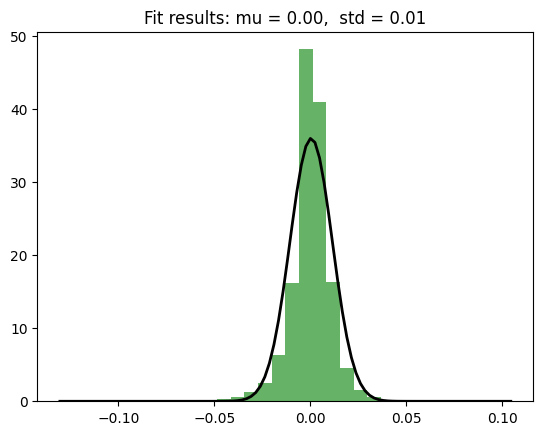

In [205]:
# Assume 'daily_return' is a Series or a single column DataFrame
returns = tickerDf['daily_return'].dropna()  # Remove NaN values for plotting

# Plot histogram
plt.hist(returns, bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF of the normal distribution using returns' mean and standard deviation
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, returns.mean(), returns.std())
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mu = %.2f,  std = %.2f" % (returns.mean(), returns.std())
plt.title(title)

plt.show()


In [206]:
transition_matrix = pd.crosstab(tickerDf['state'], tickerDf['state'].shift(-1), normalize='index')

print(transition_matrix)

state      down        up
state                    
down   0.437422  0.562578
up     0.476393  0.523607


In [207]:
# Define the model
n_components = 2  # for example, 'volatile' and 'stable'

# Initialize the HMM
model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)

# Prepare the data (the observed sequence of daily returns)
returns = tickerDf['daily_return'].dropna().values
returns = returns.reshape(-1, 1)  # hmmlearn expects a 2D array

# Train the HMM
model.fit(returns)

# Predict the hidden states
hidden_states = model.predict(returns)

In [209]:
# Prepare the data (the observed sequence of daily returns)
returns = tickerDf['daily_return'].dropna().values
returns = returns.reshape(-1, 1)  # hmmlearn expects a 2D array

# Predict the hidden states for the entire series
hidden_states = model.predict(returns)

# Infer the direction for each day based on the model's predictions
predicted_directions = []
for i in range(len(hidden_states)-1):  # exclude the last day since there's no next day to predict
    current_state = hidden_states[i]
    next_state_probs = model.transmat_[current_state]
    next_state = np.argmax(next_state_probs)
    predicted_mean_return = model.means_[next_state][0]
    predicted_directions.append('up' if predicted_mean_return > 0 else 'down')

# Append the last day's prediction
# This prediction assumes the same state as the last known state since there's no future data
predicted_directions.append('up' if model.means_[hidden_states[-1]][0] > 0 else 'down')

# Insert the predicted directions into the DataFrame
tickerDf['predicted_direction'] = ['up'] + predicted_directions  # add 'up' as a placeholder for the first day

# Now, calculate the accuracy
tickerDf['actual_next_day_direction'] = np.where(tickerDf['daily_return'].shift(-1) >= 0, 'up', 'down')
tickerDf = tickerDf[:-1]  # Remove the last row as there's no actual next day to compare

# Calculate the accuracy
accuracy = np.mean(tickerDf['predicted_direction'] == tickerDf['actual_next_day_direction'])
print(f"Prediction accuracy: {accuracy:.2%}")

# Print the DataFrame to see the actual vs predicted
print(tickerDf[['Date', 'daily_return', 'actual_next_day_direction', 'predicted_direction']])


Prediction accuracy: 54.81%
            Date  daily_return actual_next_day_direction predicted_direction
0     2010-01-04           NaN                        up                  up
1     2010-01-05      0.003116                        up                  up
2     2010-01-06      0.000546                        up                  up
3     2010-01-07      0.004001                        up                  up
4     2010-01-08      0.002882                        up                  up
...          ...           ...                       ...                 ...
3478  2023-10-27     -0.004800                        up                  up
3479  2023-10-30      0.012010                        up                  up
3480  2023-10-31      0.006475                        up                  up
3481  2023-11-01      0.010506                        up                  up
3482  2023-11-02      0.018859                        up                  up

[3483 rows x 4 columns]


Prediction

In [ ]:
# Predict the hidden state for the next day
last_state = hidden_states[-1]
next_state_probs = model.transmat_[last_state]
next_state = np.argmax(next_state_probs)

# Predict the next observation given the predicted state
next_obs_mean = model.means_[next_state]
next_obs_variance = model.covars_[next_state]

# Generate a possible next observation (daily return)
predicted_return = np.random.normal(next_obs_mean, np.sqrt(next_obs_variance))
print('this is prediction', predicted_return)

# Assume 'model' is your trained HMM
# 'returns' is your observed data (the daily returns)

# Step 1: Predict the hidden state for the last observed return
last_state = model.predict(returns)[-1]

# Step 2: Get the transition probabilities for the next state
next_state_probs = model.transmat_[last_state]

# Step 3: Use the emission probability of the next state to infer direction
next_state = np.argmax(next_state_probs)
predicted_mean_return = model.means_[next_state][0]

# If the mean return for the predicted next state is positive, you might infer an up day.
# If the mean return is negative, you might infer a down day.
predicted_direction = 'up' if predicted_mean_return > 0 else 'down'

print(f"The model predicts a {predicted_direction} day.")